# Task 4 - Introspection
Team Members

*   Libin Kutty
*   Viju Sudhi
*   Ritu Gahir

In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

# 4.1 Gradient Based Saliency Map

In [3]:
def model():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=(32,32,3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

  model.add(Dense(64))
  #model.add(Activation('relu'))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  return model

In [4]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.cifar10.load_data()

train_imgs = (train_imgs.astype(np.float32) / 255.).reshape((-1, 32, 32, 3))
train_lbls = train_lbls.astype(np.int32)

test_imgs = (test_imgs.astype(np.float32) / 255.).reshape((-1, 32, 32, 3))
test_lbls = test_lbls.astype(np.int32)

batch_size = 128

train_data = tf.data.Dataset.from_tensor_slices((train_imgs, train_lbls))

train_data = train_data.shuffle(train_imgs.shape[0])
train_data = train_data.batch(batch_size)
train_data = train_data.repeat(10)


test_data = tf.data.Dataset.from_tensor_slices((test_imgs, test_lbls))
test_data = test_data.batch(1)

170500096/170498071 [==============================] - 6s 0us/step


In [5]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [6]:
def train(model):
  step_graph = []
  loss_graph = []
  acc_graph = []
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  opt = tf.optimizers.Adam()

  for step, (img_batch, lbl_batch) in enumerate(train_data):
    with tf.GradientTape() as tape:
        logits = model(img_batch)
        xent = loss_fn(lbl_batch, logits)

    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)

    opt.apply_gradients(zip(grads, varis))
    
    train_acc_metric(lbl_batch, logits)
    
    if not step % 100:
      step_graph.append(step)
      loss_graph.append(xent)
      acc_graph.append(train_acc_metric.result())
      print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
      train_acc_metric.reset_states()
  
  return step_graph, loss_graph, acc_graph

In [7]:
def test(model):
  test_acc_metric = tf.metrics.SparseCategoricalAccuracy()
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  for img_batch, lbl_batch in test_data:
    logits = model(img_batch)
    xent = loss_fn(lbl_batch, logits) 
    test_acc_metric(lbl_batch, logits)
  print(test_acc_metric.result())
  return test_acc_metric.result()


In [8]:
model1 = model()

step1, loss1, acc1 = train(model1)

Loss: 2.3020782470703125 Accuracy: 0.078125
Loss: 2.143481731414795 Accuracy: 0.2228125035762787
Loss: 2.0936923027038574 Accuracy: 0.33000001311302185
Loss: 2.051497220993042 Accuracy: 0.37992188334465027
Loss: 2.1266798973083496 Accuracy: 0.39044857025146484
Loss: 2.039794683456421 Accuracy: 0.4232812523841858
Loss: 2.017426013946533 Accuracy: 0.4357031285762787
Loss: 1.984022617340088 Accuracy: 0.45484375953674316
Loss: 1.9340265989303589 Accuracy: 0.48839399218559265
Loss: 1.9773962497711182 Accuracy: 0.501953125
Loss: 1.9214469194412231 Accuracy: 0.5121874809265137
Loss: 1.9159786701202393 Accuracy: 0.526171863079071
Loss: 1.9581072330474854 Accuracy: 0.532700777053833
Loss: 1.963093638420105 Accuracy: 0.5582812428474426
Loss: 1.9076333045959473 Accuracy: 0.549609363079071
Loss: 1.8349192142486572 Accuracy: 0.5627343654632568
Loss: 1.9209911823272705 Accuracy: 0.5743412971496582
Loss: 1.847568392753601 Accuracy: 0.5881249904632568
Loss: 1.8751417398452759 Accuracy: 0.5884374976158

In [9]:
test_acc1 = test(model1)

tf.Tensor(0.6366, shape=(), dtype=float32)


In [10]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         7

In [11]:
model1.layers[-4]

In [12]:
layers = model1.layers[-5].output

intro_model = tf.keras.Model(inputs=model1.input, outputs=layers)

In [13]:
intro_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)         

In [14]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  #img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [15]:
i = 0
for step, (imgt_batch, lblt_batch) in enumerate(test_data):
  with tf.GradientTape() as tape:
    tape.watch(imgt_batch)      
    #logits = intro_model(imgt_batch)
    #xent = loss_fn(lblt_batch, logits)
    xent = calc_loss(imgt_batch, intro_model)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(xent, imgt_batch)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.math.sign(gradient)
  i+= 1
  break
  #if i == 2:
  #  break

In [16]:
signed_grad.shape

TensorShape([1, 32, 32, 3])

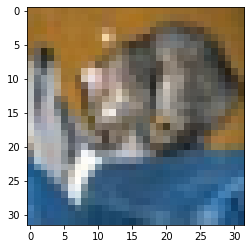

In [17]:
plt.imshow(imgt_batch[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


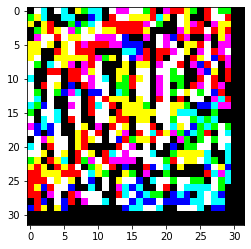

In [18]:
plt.imshow(signed_grad[0])

# 4.2 Activation Maximization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


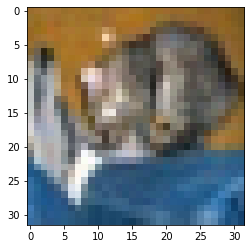

In [19]:
adv_exp = imgt_batch[0] + 0.01*signed_grad[0]
plt.imshow(adv_exp)

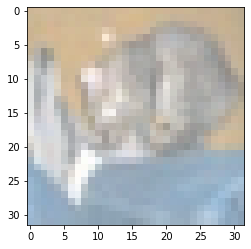

In [20]:
adv_exp = imgt_batch[0] + 0.01*signed_grad[0]
adv_exp = 255*(adv_exp + 1.0)/2.0
adv_exp = tf.cast(adv_exp, tf.uint8)
plt.imshow(adv_exp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


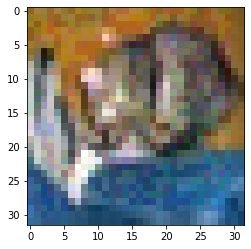

In [21]:
adv_exp = imgt_batch[0]
for _ in range(5):
  adv_exp = adv_exp + 0.01*signed_grad[0]

plt.imshow(adv_exp)

In [22]:
loss = tf.constant(0.0)
for n in tf.range(100):
  with tf.GradientTape() as tape:
    tape.watch(imgt_batch)
    loss = calc_loss(imgt_batch, intro_model)

  gradients = tape.gradient(loss, imgt_batch)

  gradients /= tf.math.reduce_std(gradients) + 1e-8 
  
  imgt_batch = imgt_batch + gradients*0.01
  imgt_batch = tf.clip_by_value(imgt_batch, -1, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


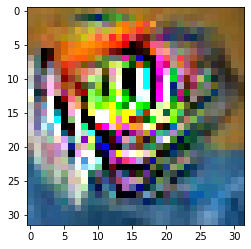

In [23]:
plt.imshow(imgt_batch[0])

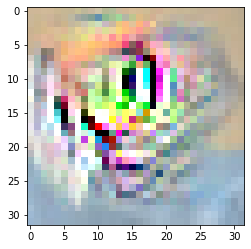

In [24]:
adv_exp = imgt_batch[0]
adv_exp = 255*(adv_exp + 1.0)/2.0
adv_exp = tf.cast(adv_exp, tf.uint8)
plt.imshow(adv_exp)

# Conclusion

---

*   Saliancy map doesnt make sense to me as the images are too small(32x32)
*   Resulting input doesnt look natural
*   After adding the signed gradient(multipied with small constant), the input image looks the same
*    After updating it many time it starts to look different. I think it shows the area which when changed will affect the classification result.

